### Short description about attempt/idea

### Import libraries

In [1]:
from torchvision import transforms
from torchvision.datasets import Cityscapes
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datasets.custom_transforms import decode_segmap

###  Dataset reader

In [2]:
from datasets import cityscapes

In [3]:
# data directory path
data_dir = '../datasets/cityscapes/'
base_size = 256
crop_size = 224

In [4]:
# dataset readers
dst_train = cityscapes.CityscapesSegmentation(crop_size, base_size, root=data_dir, split='train')

Found 2975 train images


In [5]:
dst_val = cityscapes.CityscapesSegmentation(crop_size, base_size, root=data_dir, split='val')

Found 500 val images


### Visualization

In [6]:
from datasets.custom_transforms import unNormalize

(-0.5, 223.5, 223.5, -0.5)

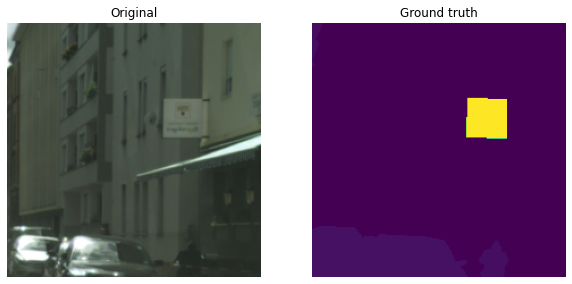

In [7]:
# n = np.random.randint(0, high=len(dst_train))
n=21
sample = dst_train[n]
img, segmap = sample['image'], sample['label']
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1,2,1)
img = img.data.numpy() # data in image and current form of matrix
img = unNormalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # unNormalize
img = img.transpose((1,2,0)).astype(np.uint8) # change dtype to correct format for display
plt.title('Original')
plt.imshow(img) # original
plt.axis('off')

# ground truth
fig.add_subplot(1, 2, 2)
label = segmap.data.numpy() # data in image and current form of matrix
# label = decode_segmap(label)
plt.title('Ground truth')
plt.imshow(label) 
plt.axis('off')

### Visual from dataloader (move to last to view predictions)

In [8]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datasets.custom_transforms import decode_segmap

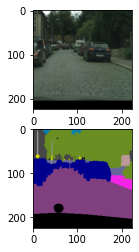

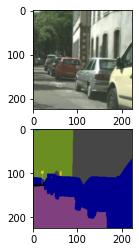

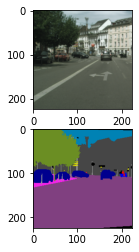

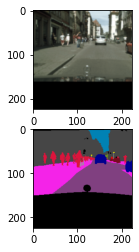

In [9]:
dataloader = DataLoader(dst_train, batch_size=2, shuffle=True, num_workers=2)

for ii, sample in enumerate(dataloader):
    for jj in range(sample["image"].size()[0]):
        img = sample['image'].numpy()
        gt = sample['label'].numpy()
        tmp = np.array(gt[jj]).astype(np.uint8)
        segmap = decode_segmap(tmp, nc=19, dataset='cityscapes')
        img_tmp = np.transpose(img[jj], axes=[1, 2, 0])
        img_tmp *= (0.229, 0.224, 0.225)
        img_tmp += (0.485, 0.456, 0.406)
        img_tmp *= 255.0
        img_tmp = img_tmp.astype(np.uint8)
        plt.figure()
        plt.title('display')
        plt.subplot(211)
        plt.imshow(img_tmp)
        plt.subplot(212)
        plt.imshow(segmap)

    if ii == 1:
        break

plt.show(block=True)

### Dataloader

In [10]:
bs = 8
#Dataloaders
train_loader = DataLoader(dst_train, batch_size=bs, shuffle=True)
val_loader = DataLoader(dst_val, batch_size=bs,shuffle=False)

### Model

In [11]:
from models.networkT3 import DeepLab

In [12]:
device = torch.device("cuda:4")

In [13]:
model = DeepLab(num_classes=19)

In [14]:
# model.eval()
# input = torch.rand(1, 3, 513, 513)
# output = model(input)
# print(output.size())

### Hyper parameters

In [15]:
epochs = 5
lr = 3e-4
wdk = 0

In [16]:
from torch.optim import Adam, lr_scheduler
criterion = torch.nn.CrossEntropyLoss(size_average=True, ignore_index=255)
optimizer = Adam(model.parameters(), lr, (0.9, 0.999),  eps=1e-08, weight_decay=wdk) 

/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


### Model Training

In [ ]:
model = model.to(device)

loss_train = []
loss_val = []

for epoch in range(epochs):
    #Training
    model.train()
    running_loss = 0

    for i, samples in enumerate(train_loader):
        inputs = samples['image'].to(device)
        labels = samples['label'].to(device).long()
        # labels = labels.squeeze(1
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        ###accumulating loss for each batch
        running_loss += loss.item()

        if i%40 == 0:
            print("epoch{}, iter{}, loss: {}".format(epoch, i, running_loss/(bs*(i+1))))
                  
    loss_train.append(running_loss/len(train_loader))

    print("epoch{}, loss: {}".format(epoch, running_loss/len(train_loader)))
    torch.save(model.state_dict(), f'../weights/T3/epoch_{epoch}.pth')

    #Validation
    model.eval()
    running_loss_val = 0
    for i, (images, labels) in enumerate(val_loader):
        inputs = images.to(device)
        labels = labels.to(device)
        # labels = labels.squeeze(1)
             
        with torch.no_grad(): 
            outputs = model(inputs)
            # loss = criterion(outputs,labels.long())
            loss = criterion(outputs,labels)

            ###accumulating loss for each batch
            running_loss_val += loss.item()


        #if i%10 == 0:
    loss_val.append(running_loss_val/len(val_loader))
    print("epoch{}, loss: {}".format(epoch, running_loss_val/len(val_loader)))
